Sources of information for various additions:
-RMS sensitivty loss regularisation term: Sensitivity Analysis of Deep Neural Networks, Hai Shu and Hongtu Zhu. AAAI19 conference.

Libraries

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm

Device Selection

In [23]:
if torch.cuda.is_available():
    my_device = torch.device("cuda")
    print("cuda in use")
else:
    my_device = torch.device("cpu")
    print("cpu in use")

print(torch.backends.cuda.is_built())

cpu in use
False


Data-2x2 strain matrix 

In [ ]:
def target_function(x):
    x = np.array(x,dtype=np.float32)
    y = np.array(x**3 - 2*x**2 + 3*x + 14)
    return y

train_data_raw = range(-100000, 100000)
y1_raw, y2_raw = target_function(train_data_raw)

inputs = torch.tensor(list(train_data_raw), dtype=torch.float32).unsqueeze(1)
targets = torch.tensor(np.stack([y1_raw, y2_raw], axis=1), dtype=torch.float32)

In [16]:
def target_function(x):
    x = np.array(x,dtype=np.float32)
    y = np.array(x**3 - 2*x**2 + 3*x + 14,dtype=np.float32)
    y = np.sum(y)
    return torch.tensor(y,dtype=torch.float32)

inputs_raw = torch.zeros(20000,2,2,dtype=torch.float32)# 2x2 strain matrix
targets = torch.zeros(20000,dtype=torch.float32)

a = b = c = 0
cycle = torch.tensor([0,0,0],dtype=torch.int16)

for i in range(0,20000):
    cycle[torch.argmin(cycle)] += 1
    maxim = cycle[torch.argmax(cycle)]

    if maxim == 0:
        a += 1
    elif maxim == 1:
        b += 1
    else:
        c += 1

    inputs_raw[i,0,0] = a
    inputs_raw[i,1,0] = b
    inputs_raw[i,1,1] = c
    inputs_raw[i,:,:] = b
    targets[i] = target_function(inputs_raw[i])


inputs = torch.flatten(inputs_raw).view(-1,4) # (N,features)
targets = targets.unsqueeze(1)

# gives an input array of 20000,4 and a target array of 20000,1

C:\Users\samue\AppData\Local\Temp\ipykernel_34380\656577448.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x,dtype=np.float32)


plot data

torch.Size([20000, 4])

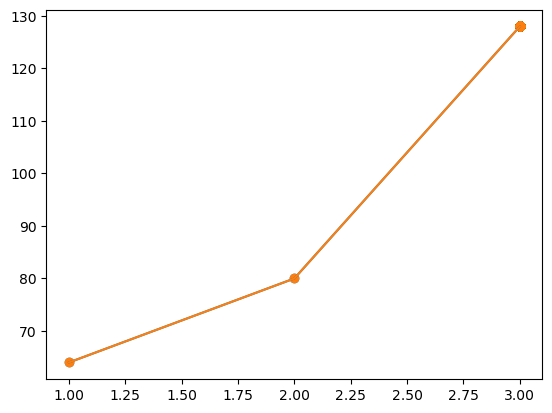

In [ ]:
plt.scatter(inputs[:,0],targets)
plt.scatter(inputs[:,1],targets)
plt.plot(inputs[:,2],targets)
plt.plot(inputs[:,3],targets)


Hyperparameters

In [17]:
Learn_Rate = 0.01
beta1 = 0.9
beta2 = 0.999
num_epochs = 100
alpha = 1.0 # weight of energy derivative loss comparative to energy loss

Model Architecture 

In [ ]:
strain_dims = 4
Layer1_output_dim = 128
Layer2_output_dim = 64
Layer3_output_dim = 32
Energy_dims = 1

class unit_approximation(nn.Module):

    def __init__(self, input_dims, output_dims):
        super().__init__()

        self.Layer1 = nn.Linear(input_dims, Layer1_output_dim)
        self.Layer2 = nn.Linear(Layer1_output_dim, Layer2_output_dim)
        self.Layer3 = nn.Linear(Layer2_output_dim, Layer3_output_dim)
        self.energy = nn.Linear(Layer3_output_dim, output_dims)


        self.relu = nn.ReLU() # Note: looking to create an activation function that would allow discontinuities
        
    def forward(self, X):
        X = self.Layer1(X)
        X = self.relu(X)
        X = self.Layer2(X)
        X = self.relu(X)
        X = self.Layer3(X)
        X = self.relu(X)
        X1 = self.energy_head(X)

        return X1

# Instantiate Model
Model = unit_approximation(strain_dims, Energy_dims)

Quantile Loss function - 

Optimiser and Loss

In [ ]:
optimiser = optim.Adam(Model.parameters(),lr=Learn_Rate,betas=(beta1,beta2))

Loss = torch.nn.MSELoss()
# Quantile Loss function can handle discontinuities but using mean square error here for ease of computation, also lloking at custom loss functions

Training Loop

In [ ]:
loss_record = []
batch_size = 20
batches_per_epoch = len(inputs) // batch_size

for epoch in range(num_epochs):

    running_loss = 0

    for i in tqdm(range(batches_per_epoch),desc=f"Epoch {epoch}/{num_epochs}", leave=False):

        start = i * batch_size 

        inputs_batch = inputs[(start* 4):((start+batch_size)*4)]
        targets_batch = targets[start:start+batch_size]

        inputs_batch.to(device=my_device)
        targets_batch.to(device=my_device)

        optimiser.zero_grad()

        energy_pred, deriv_pred = Model(inputs_batch)

        energy_target = targets_batch[:, 0].unsqueeze(1)
        deriv_target = targets_batch[:, 1].unsqueeze(1)

        loss_energy = Loss(energy_pred, energy_target)
        loss_derivative = Loss(deriv_pred, deriv_target)

        loss = loss_energy + alpha * loss_derivative

        loss.backward()
        optimiser.step()

        if torch.isnan(loss):
            print(f"Loss became NaN at batch {i} in epoch {epoch}!")
            if torch.isnan(Model.Layer1.weight).any():
                print("Model weights have been corrupted by NaN values.")
            break

        running_loss += loss.item()

    loss_record.append(running_loss)

    
        

Plot Loss

[6.118152078777008e+27, 5.949845890754029e+27, 5.722533196289207e+27, 5.478537096694955e+27, 5.241124510552014e+27, 5.069307343367083e+27, 4.918207446119155e+27, 4.7775925676806596e+27, 4.6449292945185955e+27, 4.5189910018291005e+27, 4.399052612280568e+27, 4.2846396992306445e+27, 4.1754187810051473e+27, 4.089096032984388e+27, 3.9909519603322335e+27, 3.897075383991974e+27, 3.8077021351892577e+27, 3.7225932703894385e+27, 3.641643694779577e+27, 3.564708694699643e+27, 3.491660683429953e+27, 3.4223707089089517e+27, 3.356707955113165e+27, 3.294539187225692e+27, 3.235728968903358e+27, 3.180143697199961e+27, 3.127647209875807e+27, 3.078104917407581e+27, 3.0313827235107054e+27, 2.9873485873461443e+27, 2.9458724447669454e+27, 2.906826817590247e+27, 2.8700869609578745e+27, 2.835531467414007e+27, 2.803042926486901e+27, 2.7725076771108164e+27, 2.743817210785533e+27, 2.7168659839913917e+27, 2.691554386599631e+27, 2.66778629270851e+27, 2.645470093604965e+27, 2.624519615834651e+27, 2.604852847901472e+

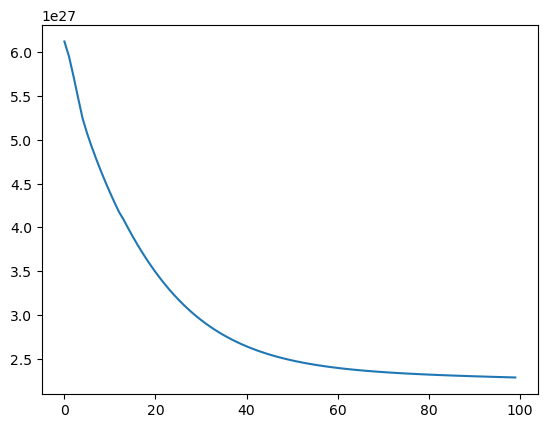

In [ ]:
plt.plot(range(num_epochs),loss_record)
print(loss_record)

Predict Outputs

[1.1410425e+08 1.7877453e+08]
[8.2147670e+06 1.1505236e+07]
[1.1410425e+08 1.7877453e+08]
[8.2147670e+06 1.1505236e+07]
